In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

from qiskit.circuit import Parameter

# Storing results in a dictionary
from qiskit.transpiler import PassManager
# Unroller transpile our circuit into CNOTs and U gates
from qiskit.transpiler.passes import Unroller

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-05-05 02:04:36,853: Credentials are already in use. The existing account in the session will be replaced.


In [205]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.drivers import UnitsType

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock, UCCSD

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

In [206]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

In [207]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [208]:
def lih_initial_state_preparation(molecule, mapper_str: str = "pa"):
    
    # molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.735"
    driver = PySCFDriver(atom=molecule, basis="sto3g")
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    if mapper_str == "pa":
        # Used with Parity mapper
        qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1])
        print("z2symmetry_reduction=[1, 1, 1, 1]")
    elif mapper_str == "jw":
        # Used with Jordan-Wigner mapper
        qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1, 1, 1])
        print("z2symmetry_reduction=[1, 1]")
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [209]:
def h2_initial_state_preparation(molecule, mapper_str: str = "pa"):
    
    # molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.735"
    driver = PySCFDriver(atom=molecule, basis="sto3g")
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [210]:
def ry_ansatz():
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ["ry"]
    # Entangling gates
    entanglement_blocks = "cx"
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False

    ansatz = TwoLocal(
        qubit_op.num_qubits,
        rotation_blocks,
        entanglement_blocks,
        reps=repetitions,
        entanglement=entanglement,
        skip_final_rotation_layer=skip_final_rotation_layer,
        # insert_barriers=True,
        name="RY"
    )

    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [211]:
def ryrz_ansatz():
    # Setting up TwoLocal for our ansatz
    ansatz_type = "RYRZ"

    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ["ry", "rz"]
    # Entangling gates
    entanglement_blocks = "cx"
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False

    ansatz = TwoLocal(
        qubit_op.num_qubits,
        rotation_blocks,
        entanglement_blocks,
        reps=repetitions,
        entanglement=entanglement,
        skip_final_rotation_layer=skip_final_rotation_layer,
        name="RYRZ",
        # insert_barriers=True
    )

    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [212]:
def uccsd_ansatz():
    ansatz_type = "UCCSD"

    ansatz = UCCSD(
        qubit_converter=qubit_converter,
        num_particles=num_particles,
        num_spin_orbitals=num_spin_orbitals,
        reps=1,
        initial_state=init_state,
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [246]:
def a_ansatz4():
    theta = Parameter("t")
    phi = Parameter("p")

    R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
    R.ry(theta + (0.5 * np.pi), 0)
    R.rz(phi + np.pi, 0)

    Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
    Rd.ry(theta + (0.5 * np.pi), 0).inverse()
    Rd.rz(phi + np.pi, 0).inverse()

    a_var_form = QuantumCircuit(2)#qubit_op.num_qubits)
    a_var_form.cx(1, 0)
    a_var_form.append(Rd, [1])
    a_var_form.cx(0, 1)
    a_var_form.append(R, [1])
    a_var_form.cx(1, 0)

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = [ a_var_form ],
        entanglement_blocks = [ a_var_form ],
        entanglement = [[1, 2], [3, 4], [5, 6]],
        reps=2,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer = True,
        # parameter_prefix = theta,
        insert_barriers = True,
        # initial_state = init_state,
        name = "$A(\\theta, \phi)$"
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

def a_ansatz2():
    theta = Parameter("t")
    phi = Parameter("p")

    R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
    R.ry(theta + (0.5 * np.pi), 0)
    R.rz(phi + np.pi, 0)

    Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
    Rd.ry(theta + (0.5 * np.pi), 0).inverse()
    Rd.rz(phi + np.pi, 0).inverse()

    a_var_form = QuantumCircuit(2)#qubit_op.num_qubits)
    a_var_form.cx(1, 0)
    a_var_form.append(Rd, [1])
    a_var_form.cx(0, 1)
    a_var_form.append(R, [1])
    a_var_form.cx(1, 0)

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = [ a_var_form ],
        entanglement_blocks = None,
        entanglement = None,
        reps=1,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer = True,
        # parameter_prefix = theta,
        insert_barriers = True,
        # initial_state = init_state,
        name = "$A(\\theta, \phi)$"
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [247]:
def at_ansatz4():
    theta = Parameter("t")
    phi = Parameter("p")

    R = QuantumCircuit(1, name="$R(\\theta)$")
    R.ry(theta + (0.5 * np.pi), 0)
    R.rz(0 + np.pi, 0)

    Rd = QuantumCircuit(1, name="$R(\\theta)^\dagger$")
    Rd.ry(theta + (0.5 * np.pi), 0).inverse()
    Rd.rz(0 + np.pi, 0).inverse()

    a_var_form = QuantumCircuit(2)#qubit_op.num_qubits)
    a_var_form.cx(1, 0)
    a_var_form.append(Rd, [1])
    a_var_form.cx(0, 1)
    a_var_form.append(R, [1])
    a_var_form.cx(1, 0)

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = [ a_var_form ],
        entanglement_blocks = [ a_var_form ],
        entanglement = [[1, 2], [3, 4], [5, 6]],
        reps=2,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer = True,
        # parameter_prefix = theta,
        insert_barriers = True,
        # initial_state = init_state,
        name = "$A(\\theta)$"
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

def at_ansatz2():
    theta = Parameter("t")
    phi = Parameter("p")

    R = QuantumCircuit(1, name="$R(\\theta)$")
    R.ry(theta + (0.5 * np.pi), 0)
    R.rz(0 + np.pi, 0)

    Rd = QuantumCircuit(1, name="$R(\\theta)^\dagger$")
    Rd.ry(theta + (0.5 * np.pi), 0).inverse()
    Rd.rz(0 + np.pi, 0).inverse()

    a_var_form = QuantumCircuit(2)#qubit_op.num_qubits)
    a_var_form.cx(1, 0)
    a_var_form.append(Rd, [1])
    a_var_form.cx(0, 1)
    a_var_form.append(R, [1])
    a_var_form.cx(1, 0)

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = [ a_var_form ],
        entanglement_blocks = None,
        entanglement = None,
        reps=1,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer = True,
        # parameter_prefix = theta,
        insert_barriers = True,
        # initial_state = init_state,
        name = "$A(\\theta)$"
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [248]:
h2_init_file = "init_state_h2_z2sr_"
lih_init_file = "init_state_lih_z2sr_"

# Initial States

## $H_2$

### Parity Mapper

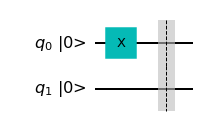

In [216]:
molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.735"
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = h2_initial_state_preparation(molecule, "pa")

init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
init_state.barrier()

large_font = {
    "fontsize": 13,
    "subfontsize": 12,  
}

# h2_init_file += "pa.png"
init_state.draw("mpl", initial_state=True, style=large_font).savefig(h2_init_file+"pa.png", dpi=200)
init_state.draw("mpl", initial_state=True, style=large_font)

#### RY

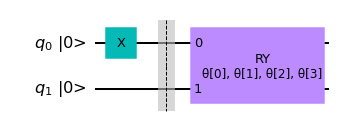

In [217]:
ansatz = ry_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("ry_ansatz_h2_pa.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

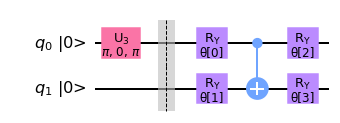

In [218]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("ry_ansatz_h2_pa_decomposed.png", dpi=200)
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### RYRZ

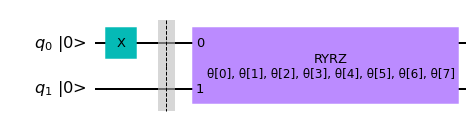

In [219]:
ansatz = ryrz_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("ryrz_ansatz_h2_pa.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

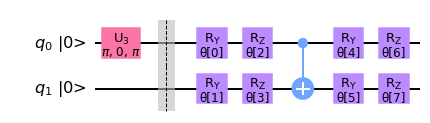

In [220]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("ryrz_ansatz_h2_pa_decomposed.png", dpi=200)
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### UCCSD

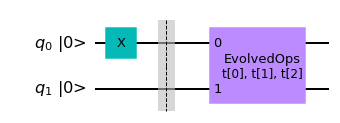

In [221]:
ansatz = uccsd_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("uccsd_ansatz_h2_pa.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

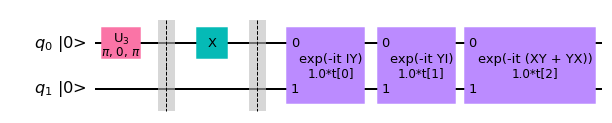

In [222]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("uccsd_ansatz_h2_pa_decomposed.png", dpi=200)
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### A

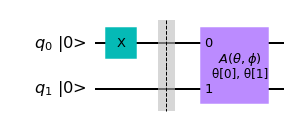

In [223]:
ansatz = a_ansatz2()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("a_ansatz_h2_pa.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

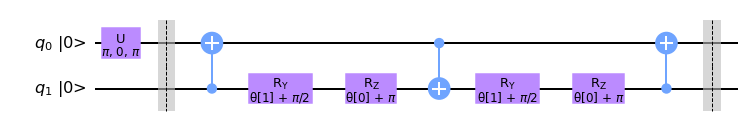

In [224]:
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("a_ansatz_h2_pa_decomposed.png", dpi=200)
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font)

#### AT

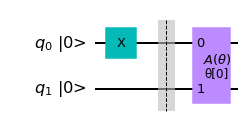

In [225]:
ansatz = at_ansatz2()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("at_ansatz_h2_pa.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

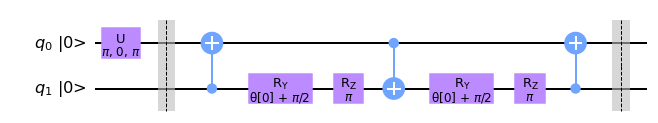

In [226]:
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("at_ansatz_h2_pa_decomposed.png", dpi=200)
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font)

### Jordan-Wigner mapper

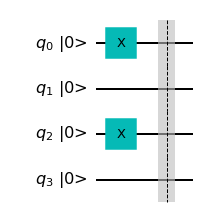

In [227]:
molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.735"
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = h2_initial_state_preparation(molecule, "jw")

init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
init_state.barrier()

# h2_init_file += "jw.png"
init_state.draw("mpl", initial_state=True, style=large_font).savefig(h2_init_file+"jw.png", dpi=200)
init_state.draw("mpl", initial_state=True, style=large_font)

#### RY

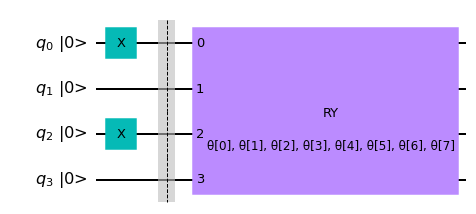

In [228]:
ansatz = ry_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("ry_ansatz_h2_jw.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

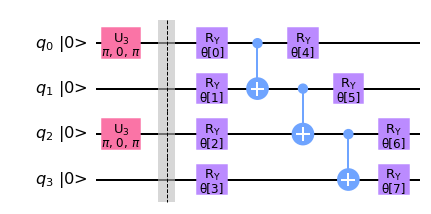

In [229]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("ry_ansatz_h2_jw_decomposed.png", dpi=200)
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### RYRZ

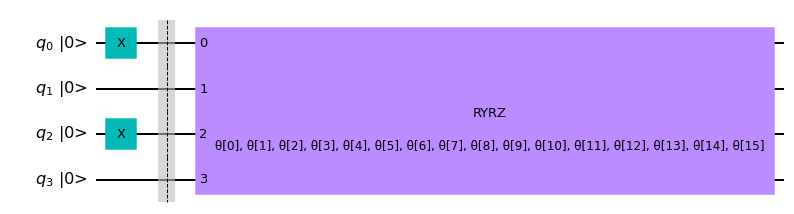

In [230]:
ansatz = ryrz_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("ryrz_ansatz_h2_jw.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

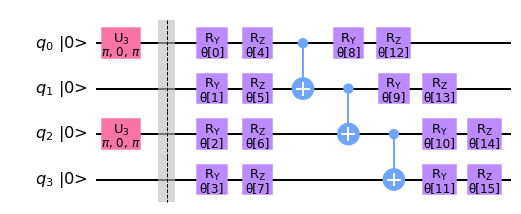

In [231]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("ryrz_ansatz_h2_jw_decomposed.png", dpi=200)
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### UCCSD

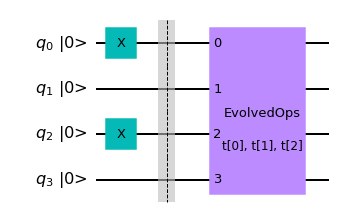

In [232]:
ansatz = uccsd_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("uccsd_ansatz_h2_jw.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

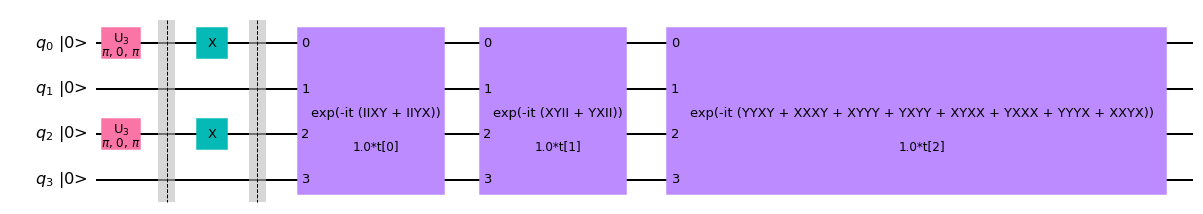

In [233]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("uccsd_ansatz_h2_jw_decomposed.png", dpi=200)
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### A

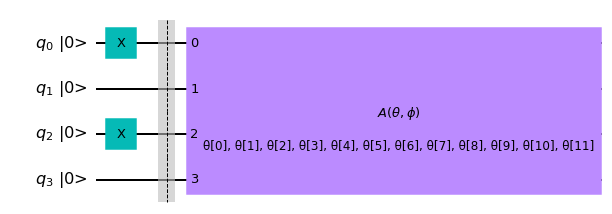

In [234]:
ansatz = a_ansatz4()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("a_ansatz_h2_jw.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

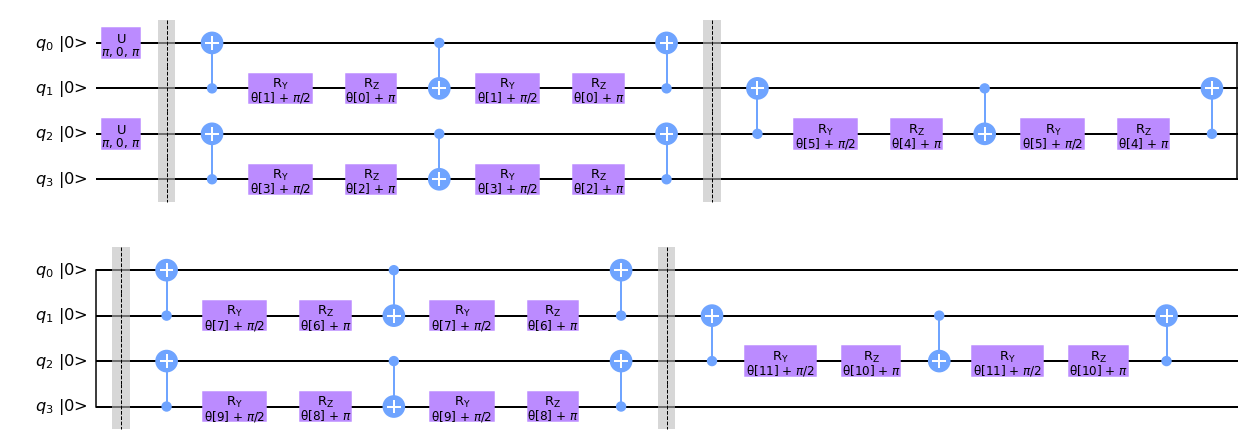

In [235]:
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("a_ansatz_h2_jw_decomposed.png", dpi=200)
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font)

#### AT

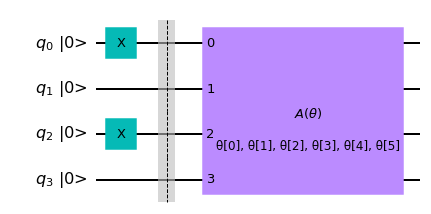

In [236]:
ansatz = at_ansatz4()
ansatz.draw(output="mpl", initial_state=True, style=large_font).savefig("at_ansatz_h2_jw.png", dpi=200)
ansatz.draw(output="mpl", initial_state=True, style=large_font)

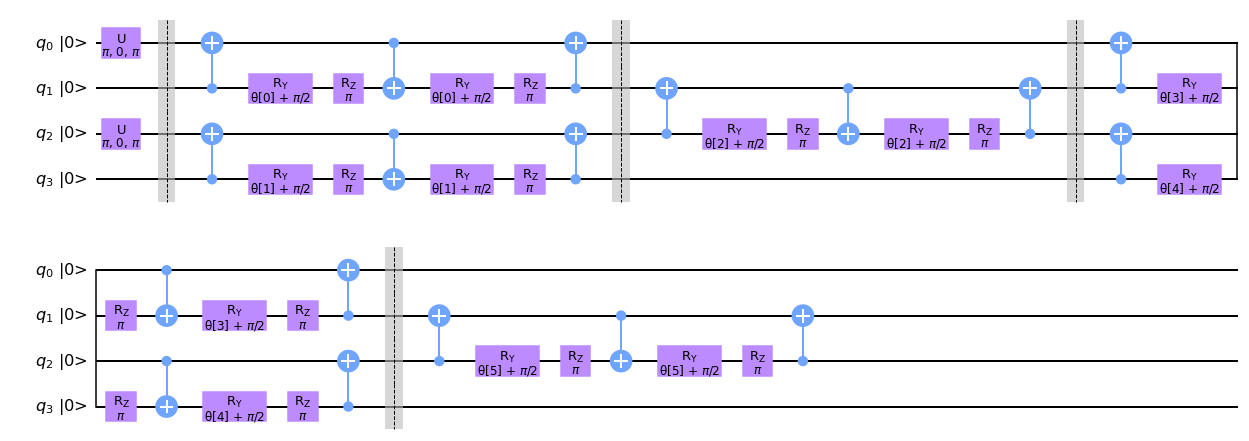

In [237]:
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font).savefig("at_ansatz_h2_jw_decomposed.png", dpi=200)
ansatz.decompose().decompose().draw(output="mpl", initial_state=True, style=large_font)

## $LiH$

### Parity mapper

z2symmetry_reduction=[1, 1, 1, 1]


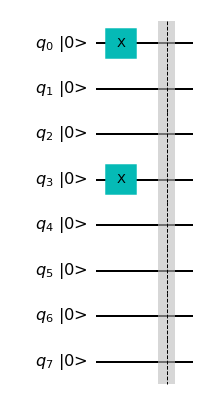

In [249]:
molecule = "Li 0.0 0.0 0.0; H 0.0 0.0 1.5474"
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = lih_initial_state_preparation(molecule, "pa")

init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
init_state.barrier()

# lih_init_file += "pa.png"
init_state.draw("mpl", initial_state=True, style=large_font).savefig(lih_init_file+"pa.png", dpi=200)
init_state.draw("mpl", initial_state=True, style=large_font)

#### RY

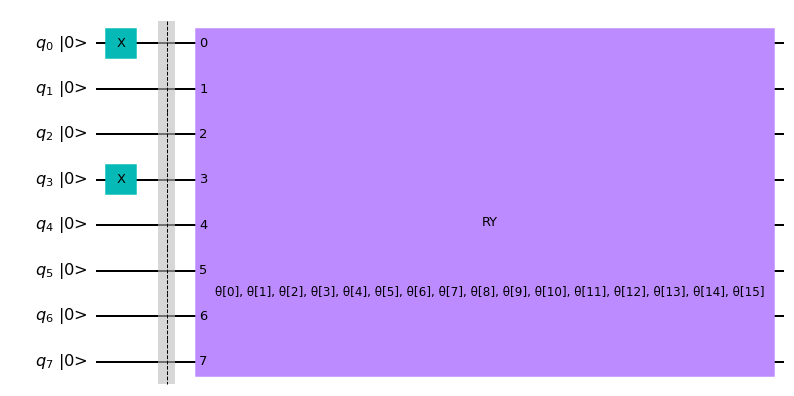

In [148]:
ansatz = ry_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

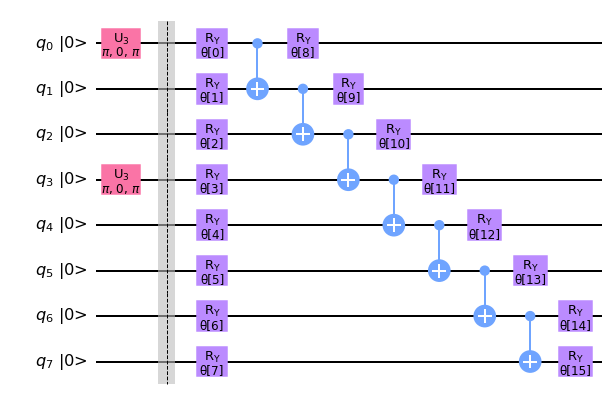

In [149]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### RYRZ

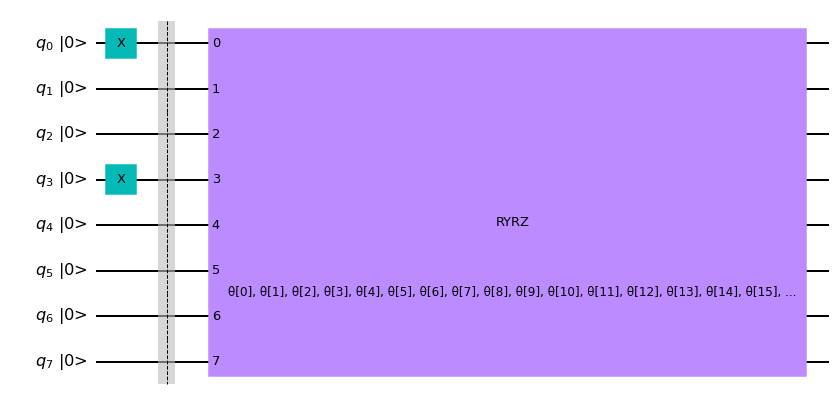

In [150]:
ansatz = ryrz_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

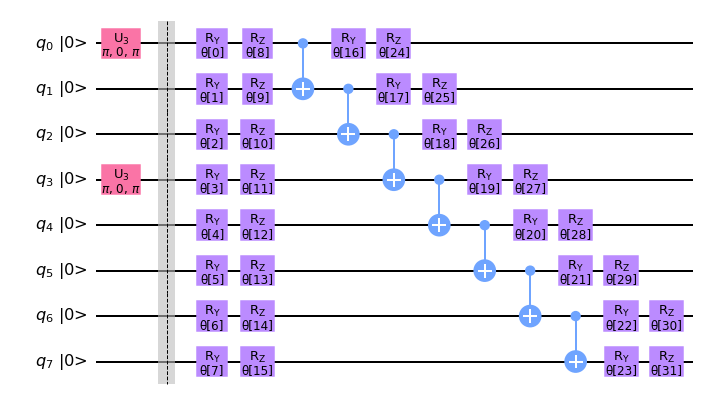

In [151]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### UCCSD 

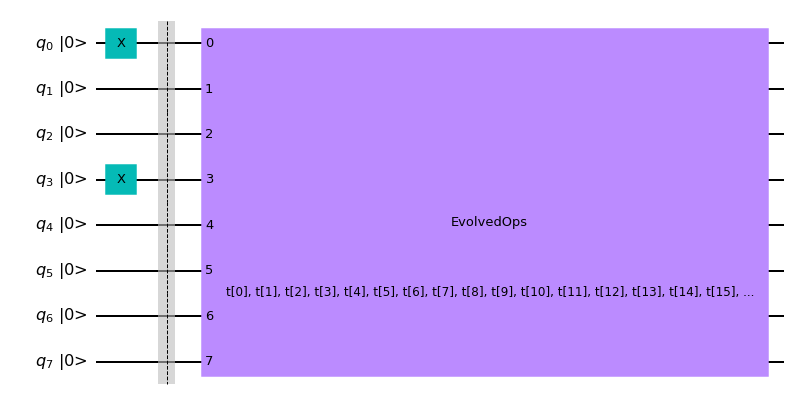

In [152]:
ansatz = uccsd_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

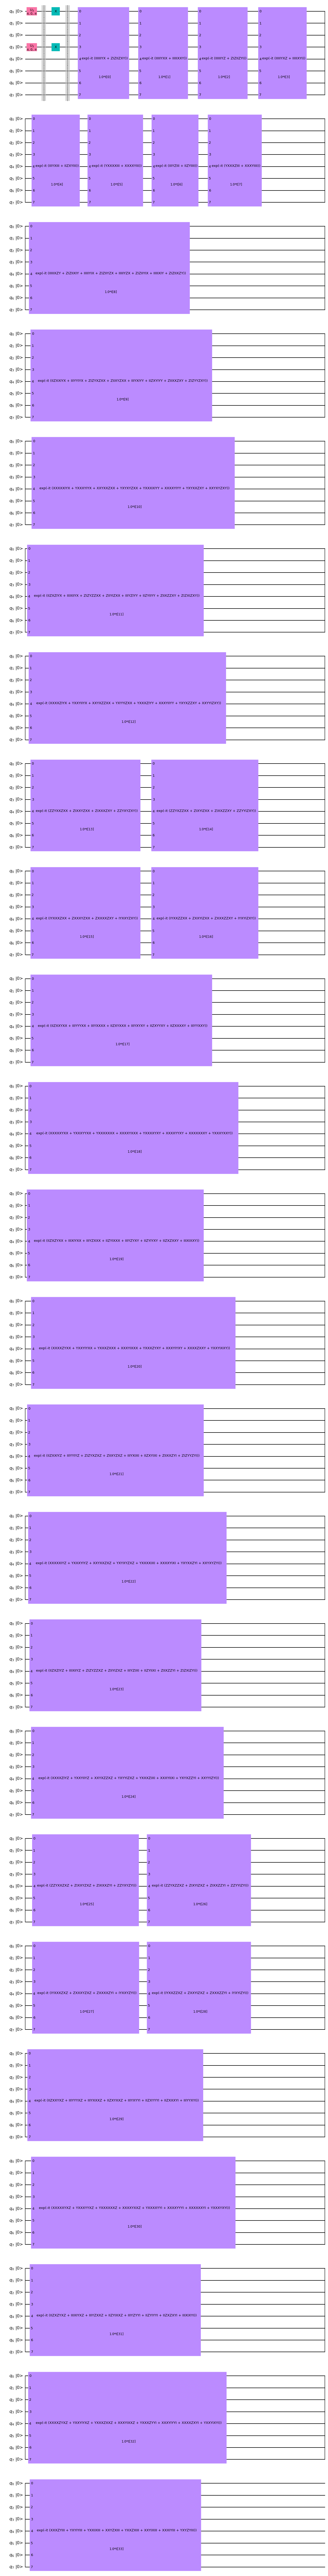

In [153]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### A

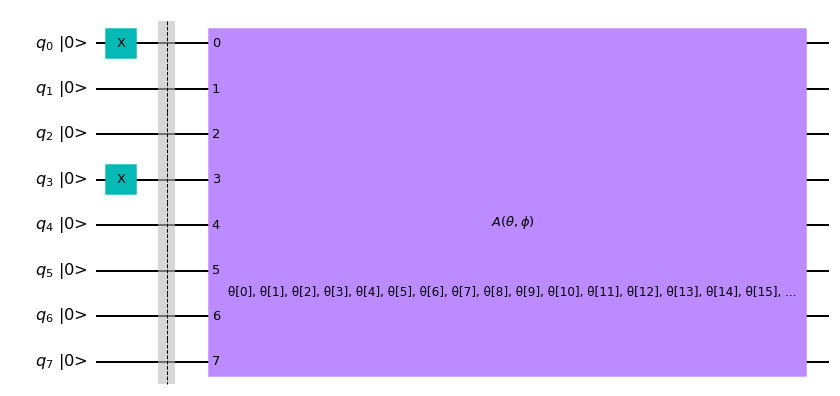

In [252]:
ansatz = a_ansatz4()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

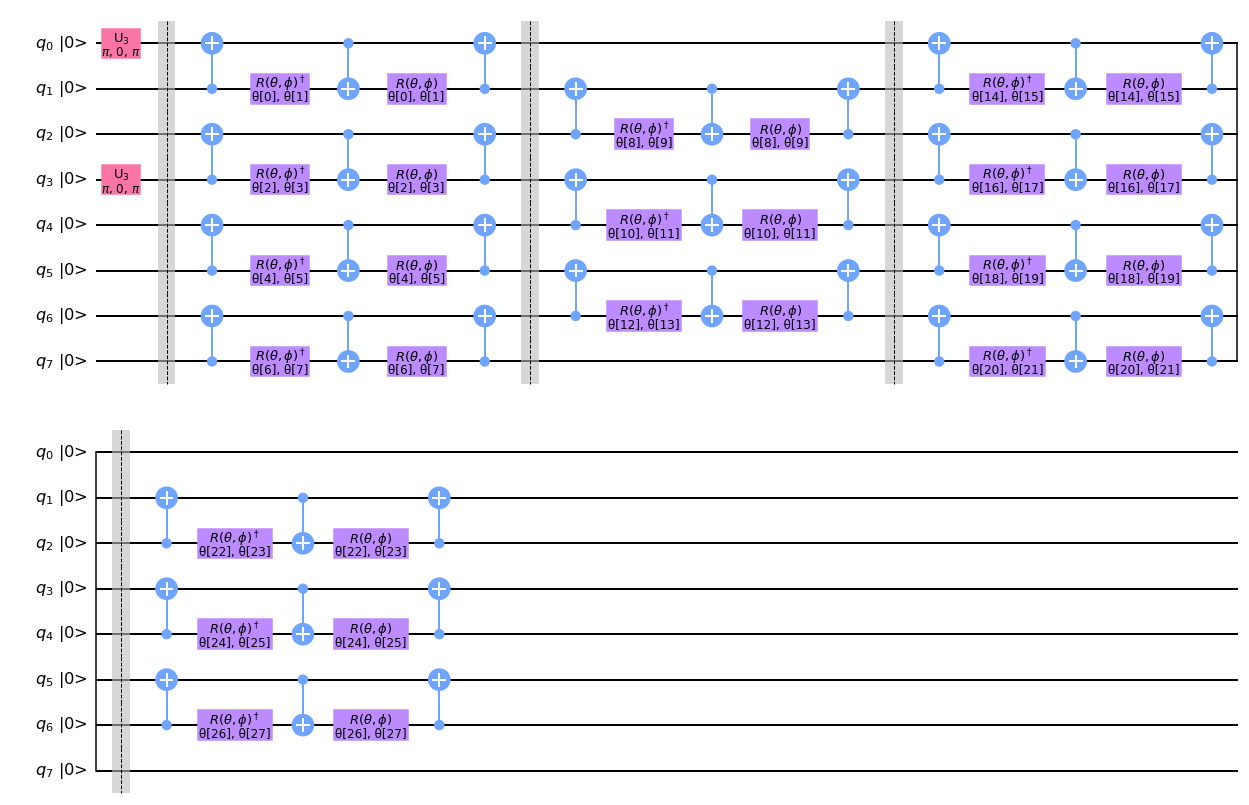

In [253]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### AT

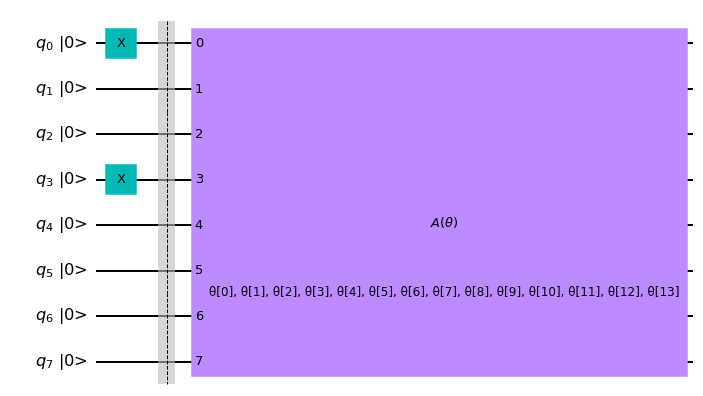

In [254]:
ansatz = at_ansatz4()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

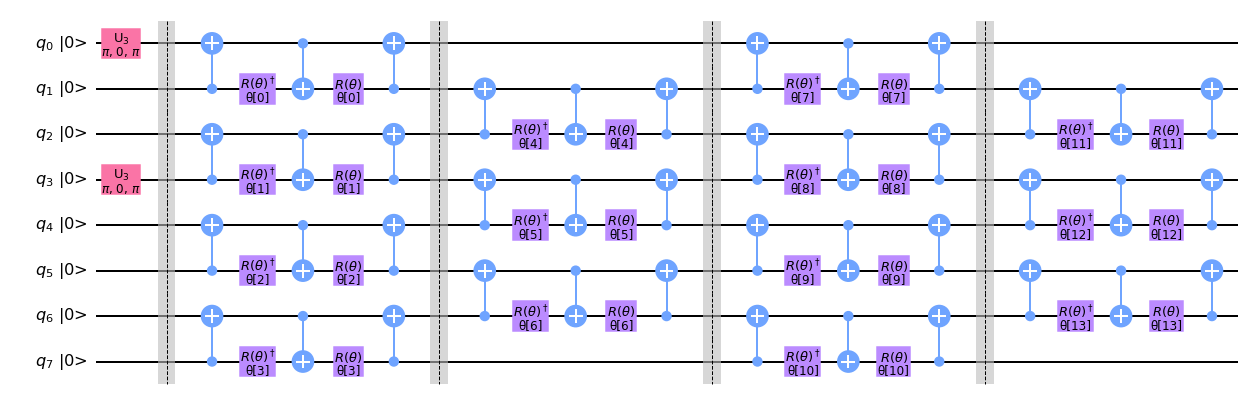

In [255]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

### Jordan-Wigner mapper

z2symmetry_reduction=[1, 1]


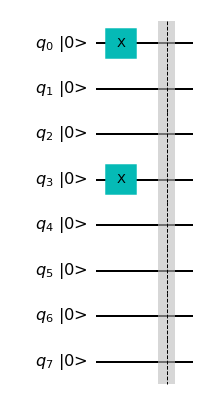

In [158]:
molecule = "Li 0.0 0.0 0.0; H 0.0 0.0 1.5474"
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = lih_initial_state_preparation(molecule, "jw")

init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
init_state.barrier()

# lih_init_file += "jw.png"
init_state.draw("mpl", initial_state=True, style=large_font).savefig(lih_init_file+"jw.png", dpi=200)
init_state.draw("mpl", initial_state=True, style=large_font)

#### RY

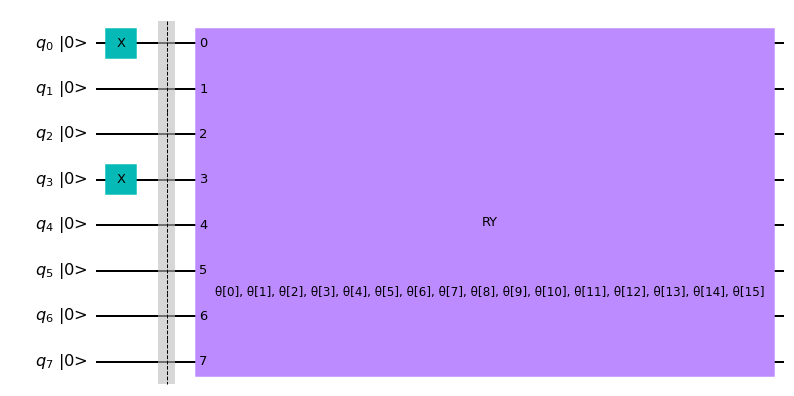

In [159]:
ansatz = ry_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

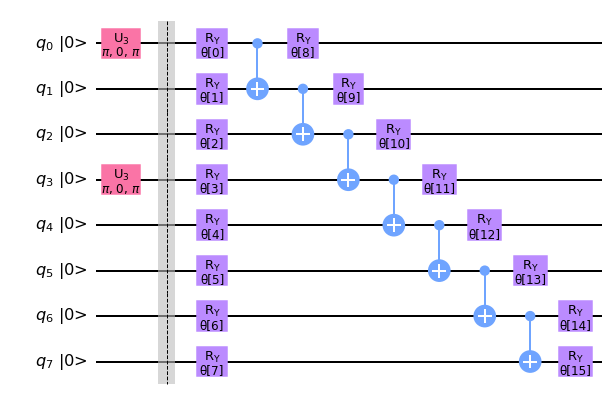

In [160]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### RYRZ

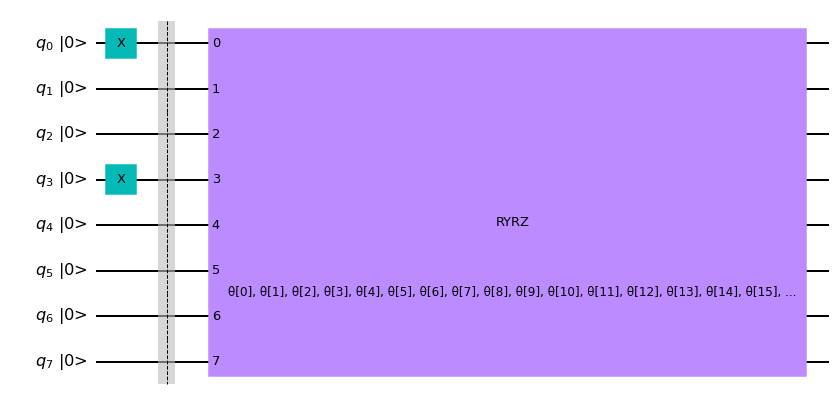

In [161]:
ansatz = ryrz_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

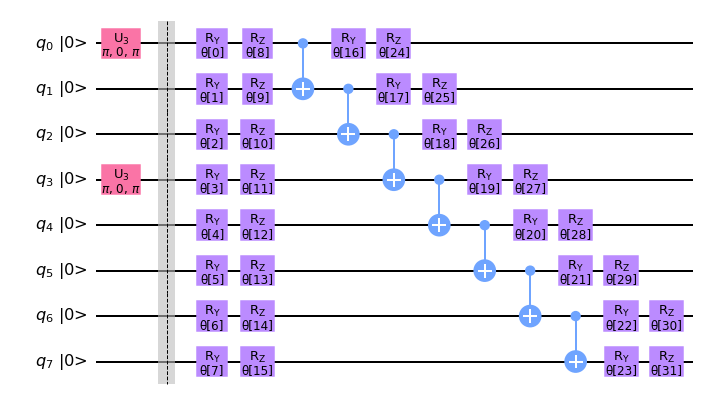

In [162]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### UCCSD

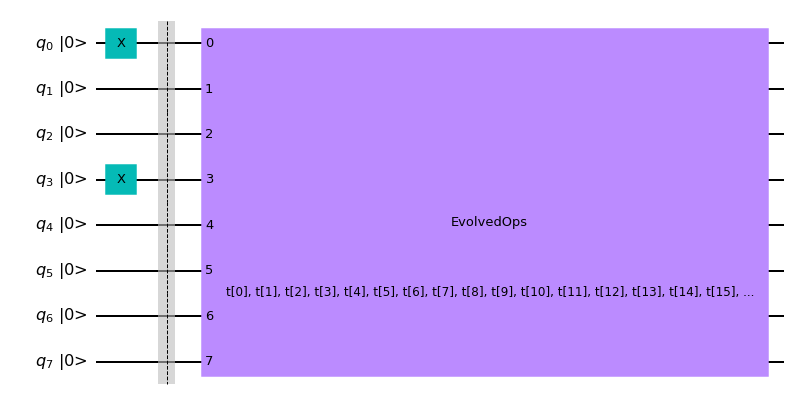

In [163]:
ansatz = uccsd_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

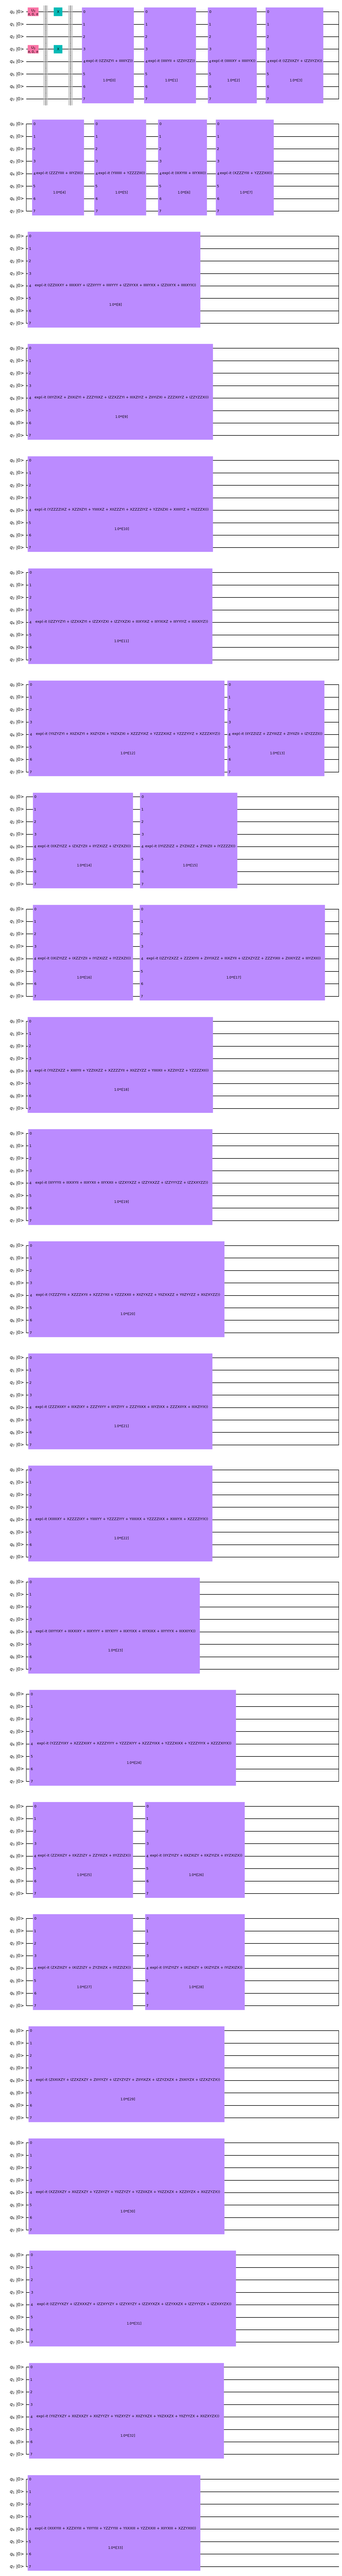

In [164]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### A

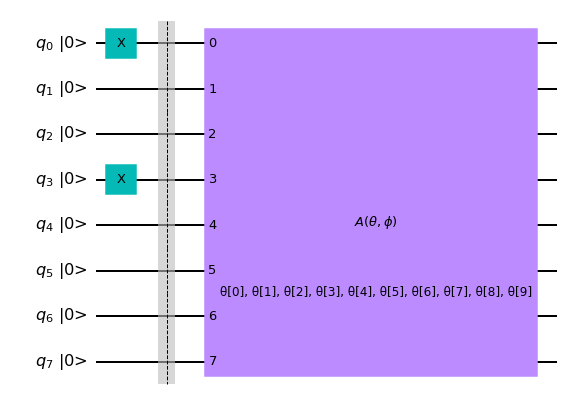

In [165]:
ansatz = a_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

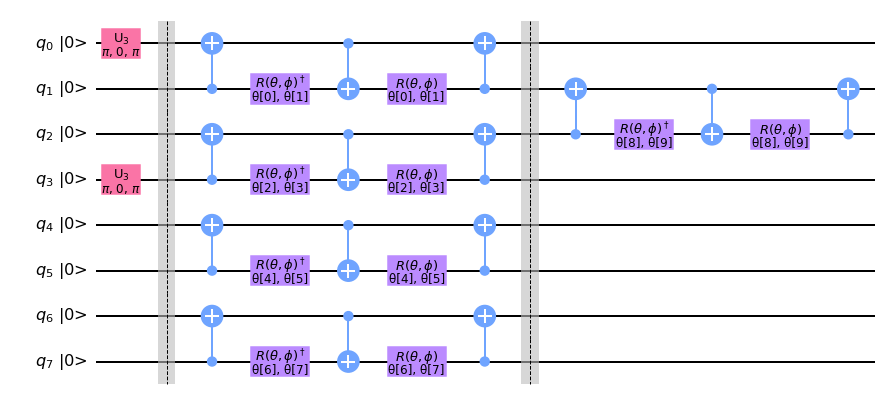

In [166]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)

#### AT

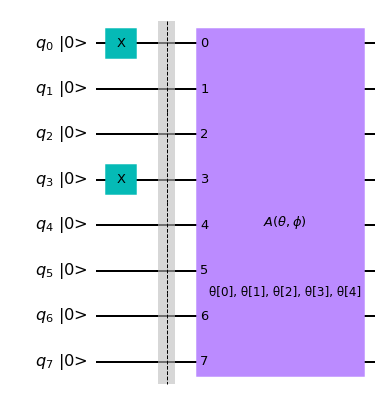

In [167]:
ansatz = at_ansatz()
ansatz.draw(output="mpl", initial_state=True, style=large_font)

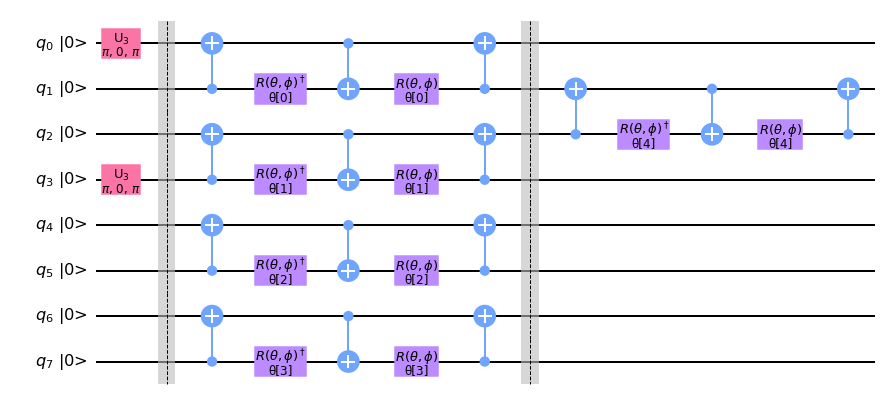

In [168]:
ansatz.decompose().draw(output="mpl", initial_state=True, style=large_font)